In [1]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
from mirtorch.alg import CG, FISTA, POGM, power_iter
from mirtorch.linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2dframe, Gmri, Wavelet2D
from mirtorch.prox import Prox, L1Regularizer
import matplotlib.pyplot as plt

import copy
import h5py
import torchkbnufft as tkbn
import os

%load_ext autoreload
%autoreload 2

### Non-Cartesian Cases

In [2]:
# Download the files
if not os.path.exists('./b0.h5'):
    import wget
    url = "https://www.dropbox.com/s/q1cr3u1yyvzjtoj/b0.h5?dl=1"
    wget.download(url, './b0.h5')

In [3]:
hf = h5py.File('./b0.h5', 'r')
nx = 320;
ny = 320;
# Load Non-cartesian k-space trajectory
ktraj = hf['ktraj'][()]
ktraj = np.remainder(ktraj + np.pi, 2*np.pi)-np.pi
print('traj shape', ktraj.shape)
# Load k-space
k = hf['k_r'][()] + 1j*hf['k_i'][()]
[ncoil, nslice, nshot, ns] = k.shape
print('k shape', k.shape)
# Load density compensation function
dcf = hf['dcf'][()]
print('dcf shape', dcf.shape)
# Load sensetivity maps
smap = np.transpose(hf['s_r'][()] + 1j*hf['s_i'][()], (3,0,1,2))
smap = np.transpose(smap, (0,1,3,2))
[_, _, nx, ny] = smap.shape
print('smap shape', smap.shape)
# Load fmaps
fmap = hf['b0'][()]
fmap = np.transpose(fmap, (0,2,1))
print('fmap shape', fmap.shape)
# Define 5x retrospective undersampling mask
ktrajunder = ktraj.reshape(2,320,1280)
ktrajunder = ktrajunder[:,0:-1:5,:].reshape(2,81920)
kunder = k[:,:,0:-1:5,:]

traj shape (2, 409600)
k shape (32, 15, 320, 1280)
dcf shape (1, 409600)
smap shape (15, 32, 320, 320)
fmap shape (15, 320, 320)


In [4]:
# Load the numpy file to the pytorch, and define the operator
im_size = (nx,ny)
iz = 6
device0 = torch.device('cuda:1')
k0 = torch.tensor(kunder[:,iz,:,:]).to(device = device0).reshape(1,ncoil,nshot*ns//5).to(torch.complex64)
s0 = torch.tensor(smap[iz,:,:,:]).to(device = device0).unsqueeze(0).to(torch.complex64)
traj0 = torch.tensor(ktrajunder).to(device = device0).to(torch.float32)
Nop = NuSense(s0, traj0)

In [5]:
W = Wavelet2D([1,1,320,320], padding='periodization', J=2, wave_type = 'db4', device = device0)

In [6]:
L = power_iter(Nop.H*Nop,torch.ones([1,1,nx,ny],dtype=torch.complex64).to(device0), max_iter=200)

/home/guanhuaw/anaconda3/envs/torch/lib/python3.7/site-packages/torch/_tensor.py:579: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(other, self)


The calculation of max singular value accomplished at 5 iterations.
The spectral norm is 22.50603485107422.


In [7]:
def gradA(x):
    return Nop.H*Nop*x-Nop.H*k0

In [8]:
P = L1Regularizer(1e-4, T=W)

In [10]:
pg_radial = POGM(f_grad=gradA, f_L=L[1].item(), g_prox=P, max_iter=100).run(x0=Nop.H*k0)

Text(0.5, 1.0, 'Reconstruction: CS-POGM (w/o B0-correction)')

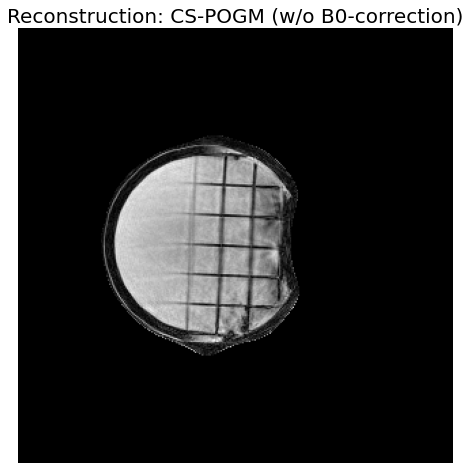

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(((torch.abs((pg_radial[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.axis('off')
plt.title('Reconstruction: CS-POGM (w/o B0-correction)',size = 20)

In [12]:
# Define field-corrected NuSENSE operator
b0 = torch.tensor(fmap[iz,:,:]).to(device0).unsqueeze(0)
Gop = Gmri(smaps=s0, zmap = -b0, traj = traj0.reshape(2,nshot//5, ns).unsqueeze(0))
k1 = torch.tensor(kunder[:,iz,:,:]).to(device = device0).reshape(1,ncoil,nshot//5, ns).to(torch.complex64)

In [13]:
L = power_iter(Gop.H*Gop,torch.ones([1,1,nx,ny],dtype=torch.complex64).to(device0), max_iter=200)

The calculation of max singular value accomplished at 6 iterations.
The spectral norm is 22.505929946899414.


In [14]:
def gradA(x):
    return Gop.H*Gop*x-Gop.H*k1

In [16]:
pg_radial_b0 = POGM(f_grad=gradA, f_L=L[1].item(), g_prox=P, max_iter=100).run(x0=Gop.H*k1)

Text(0.5, 1.0, 'Reconstruction: CS-POGM (B0-correction)')

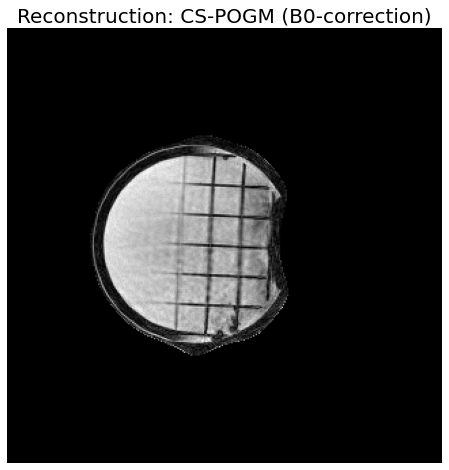

In [17]:
plt.figure(figsize=(8,8))
plt.imshow(((torch.abs((pg_radial_b0[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.axis('off')
plt.title('Reconstruction: CS-POGM (B0-correction)',size=20)